In [1]:
!pip install transformers[torch] torch
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [4]:
def load_data(csv_path):
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)

    # Ensure the dataset has necessary columns
    required_columns = {'title', 'content', 'bias_text', 'bias'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"CSV file is missing required columns: {required_columns - set(df.columns)}")

    # Drop rows with missing bias labels
    df = df.dropna(subset=['bias_text', 'bias'])

    # Ensure bias is correctly mapped to numeric values
    df['bias'] = df['bias'].astype(int)

    # Combine title and content for model input
    df['text'] = df['title'].fillna('') + " [SEP] " + df['content'].fillna('')

    print(f"Dataset loaded successfully with {len(df)} entries.")
    return df

In [8]:
def train_model():
    df = load_data("/content/bias_prediction_articles.csv")  # Load data from CSV

    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['bias'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['bias'])

    print(f"Train set: {len(train_df)}, Validation set: {len(val_df)}, Test set: {len(test_df)}")

    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # Create datasets
    train_dataset = NewsDataset(train_df['text'].tolist(), train_df['bias'].tolist(), tokenizer, 512)
    val_dataset = NewsDataset(val_df['text'].tolist(), val_df['bias'].tolist(), tokenizer, 512)
    test_dataset = NewsDataset(test_df['text'].tolist(), test_df['bias'].tolist(), tokenizer, 512)

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=3
    ).to(device)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="/content/media_bias_model",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    print("Training the model...")
    trainer.train()

    # Save model
    trainer.save_model("/content/media_bias_model")
    tokenizer.save_pretrained("/content/media_bias_model")

    # Evaluate on test set
    print("Evaluating on test set...")
    predictions = trainer.predict(test_dataset)

    # Extract labels and predictions
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids

    # Compute classification metrics
    LABEL_MAP = {"left": 0, "center": 1, "right": 2}
    report = classification_report(labels, preds, target_names=LABEL_MAP.keys(), output_dict=True)
    accuracy = report['accuracy']

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=LABEL_MAP.keys()))

    # Generate Confusion Matrix
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=LABEL_MAP.keys(),
                yticklabels=LABEL_MAP.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    plt.show()

    print(f"Accuracy: {accuracy:.4f}")

    return model, tokenizer, test_df

Loading data from /content/bias_prediction_articles.csv...
Dataset loaded successfully with 37554 entries.
Train set: 30043, Validation set: 3755, Test set: 3756


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training the model...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moham09 (moham09-pfw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.645400,0.651688
2,0.493400,0.889568
3,0.391300,0.594156
4,0.255800,0.935079
5,0.174000,1.001667


Evaluating on test set...



Classification Report:
              precision    recall  f1-score   support

        left       0.82      0.82      0.82      1301
      center       0.79      0.83      0.81      1081
       right       0.82      0.79      0.81      1374

    accuracy                           0.81      3756
   macro avg       0.81      0.81      0.81      3756
weighted avg       0.81      0.81      0.81      3756



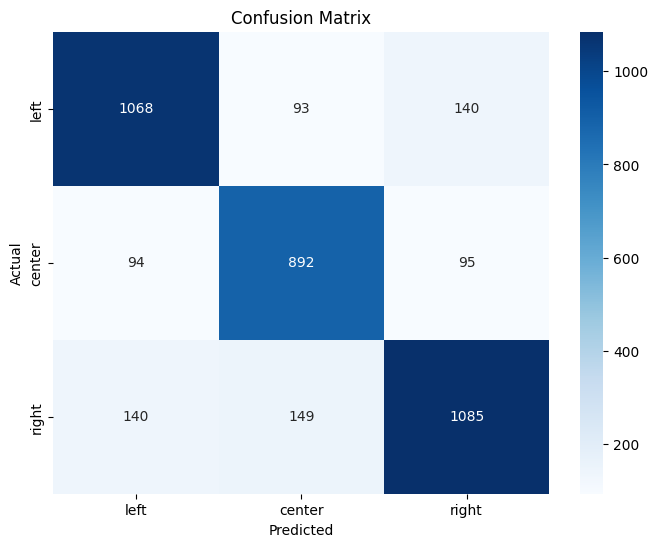

Accuracy: 0.8107


(BertForSequenceClassification(
   (bert): BertModel(
     (embeddings): BertEmbeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (token_type_embeddings): Embedding(2, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): BertEncoder(
       (layer): ModuleList(
         (0-11): 12 x BertLayer(
           (attention): BertAttention(
             (self): BertSdpaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): BertSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (LayerNorm): La

In [9]:
train_model()

In [10]:
!zip -r /content/media_bias_model.zip /content/media_bias_model
from google.colab import files
files.download('/content/media_bias_model.zip')

  adding: content/media_bias_model/ (stored 0%)
  adding: content/media_bias_model/checkpoint-3756/ (stored 0%)
  adding: content/media_bias_model/checkpoint-3756/scheduler.pt (deflated 55%)
  adding: content/media_bias_model/checkpoint-3756/model.safetensors (deflated 7%)
  adding: content/media_bias_model/checkpoint-3756/trainer_state.json (deflated 64%)
  adding: content/media_bias_model/checkpoint-3756/config.json (deflated 51%)
  adding: content/media_bias_model/checkpoint-3756/training_args.bin (deflated 52%)
  adding: content/media_bias_model/checkpoint-3756/rng_state.pth (deflated 25%)
  adding: content/media_bias_model/checkpoint-3756/optimizer.pt (deflated 11%)
  adding: content/media_bias_model/model.safetensors (deflated 7%)
  adding: content/media_bias_model/checkpoint-7512/ (stored 0%)
  adding: content/media_bias_model/checkpoint-7512/scheduler.pt (deflated 55%)
  adding: content/media_bias_model/checkpoint-7512/model.safetensors (deflated 7%)
  adding: content/media_bia

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>